# Analysis of ST Sim Output

### Algorithm

The simulation is a basic MC simulation. The termination condition is the full completion of scrolling for the item. In other words, there is no chance of the item being incomplete as that is not supported by the sim (for now). The general flow of the algorithm is as follows:

For each simulation:
1. If there is an empty slot on the item
    - First try scrolling it with normal scroll
        - If failed, attempt recovery via guild salvation skill
2. If scroll failures count currently passes the INNO_THRESH count, reset the item status and go back to 1.; otherwise, continue to 3.
3. If there is no empty slot on the item and it has some failed slots remaining
    - If no hammers have been applied
        - Use a hammer and add any additional failure / empty slot to item count
    - If all hammers have been applied
        - Use css until a slot has been opened again
4. Fall back to 1. for next step of simulation

## Data Sanity Checks

The input for this check used the following options for the sim:

```Python
{eqpSlots: 8,
 cssCost: 20 000,
 cssRate: 1.0, 
 innoCost: 12 000, 
 innoRate: 1.0,
 innoAfterTol: {1, 2, 3, 4, 5, 6, 7, 8}, 
 useHammer: y, 
 hammerCost: 0, 
 hammerRate: 0.5, 
 scrollCost: 1000, # unknown for now... >850
 scrollRate: 0.29, # 0.15 + 0.1 + 0.04
 guildSaveRate: 0.04}
```

From this, we can attempt to enforce that (across all trials), all of these probabilities line up within some epsilon determined by the number of individual trial counts performed for each operation. This should serve as a baseline sanity check for the operations.

In [1]:
# first import the results
import pickle

with open("./res_output.pkl", 'rb') as inFile:
    resDicts = pickle.load(inFile)

In [2]:
# look quickly at how our data is being indexed
resDicts.keys()

dict_keys([(('Inno Fail Count', 1),), (('Inno Fail Count', 2),), (('Inno Fail Count', 3),), (('Inno Fail Count', 4),), (('Inno Fail Count', 5),), (('Inno Fail Count', 6),), (('Inno Fail Count', 7),), (('Inno Fail Count', 8),)])

In [3]:
# and also observe the size of each test run
for keyVal in resDicts.keys():
    print("Key: {}\t\t\t Length of Res Dict: {}".format(keyVal, len(resDicts[keyVal])))

Key: (('Inno Fail Count', 1),)			 Length of Res Dict: 1000000
Key: (('Inno Fail Count', 2),)			 Length of Res Dict: 1000000
Key: (('Inno Fail Count', 3),)			 Length of Res Dict: 1000000
Key: (('Inno Fail Count', 4),)			 Length of Res Dict: 1000000
Key: (('Inno Fail Count', 5),)			 Length of Res Dict: 1000000
Key: (('Inno Fail Count', 6),)			 Length of Res Dict: 1000000
Key: (('Inno Fail Count', 7),)			 Length of Res Dict: 1000000
Key: (('Inno Fail Count', 8),)			 Length of Res Dict: 1000000


So, as we can see each data entry has about 1M entries of which the results or all formatted to be presented similar to what follows (also shown along with their data type):

In [4]:
for keyVal in resDicts.keys():
    for datElemKey in resDicts[keyVal][0].keys():
        print("Observable key in result document of {}: {}".format(type(resDicts[keyVal][0][datElemKey]), datElemKey))
    break

Observable key in result document of <class 'float'>: totalTraceCost
Observable key in result document of <class 'float'>: innoTraceCost
Observable key in result document of <class 'int'>: scrollTraceCost
Observable key in result document of <class 'int'>: cssTraceCost
Observable key in result document of <class 'int'>: hammerTraceCost
Observable key in result document of <class 'int'>: numFailedScrolls
Observable key in result document of <class 'int'>: numFailedInnos
Observable key in result document of <class 'int'>: numFailedCSS
Observable key in result document of <class 'int'>: numFailedHammers
Observable key in result document of <class 'int'>: numPassedScrolls
Observable key in result document of <class 'int'>: numPassedInnos
Observable key in result document of <class 'int'>: numPassedCSS
Observable key in result document of <class 'int'>: numPassedHammers
Observable key in result document of <class 'int'>: numGuildSaves


With that in place, we can now go and formulate a way of ingesting the data using pandas. This should allow us to quite easily manipulate the data in a way much faster than if we were to operate solely on the documents as dictionariies.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# first try ingesting via json method per key
keyDfs = list()
for keyVal in resDicts.keys():
    keyDfs.append(pd.DataFrame.from_dict(resDicts[keyVal]))

    # manipulate into containing the desired elements from keys
    for varName, varVal in keyVal:
        keyDfs[-1][varName] = varVal
    
# Then concatenate all results along with their variadic key values
resDf = pd.concat(keyDfs, axis = 0)
totUniqueCombs = len(resDicts.keys())

# And cleanup all the unnecessary garbage from the process
del keyDfs
del resDicts

In [7]:
# Take a small look at the data we have now
resDf.groupby('Inno Fail Count').head(2)

,totalTraceCost,innoTraceCost,scrollTraceCost,cssTraceCost,hammerTraceCost,numFailedScrolls,numFailedInnos,numFailedCSS,numFailedHammers,numPassedScrolls,numPassedInnos,numPassedCSS,numPassedHammers,numGuildSaves,Inno Fail Count
0,1594450.0,1032000.0,302450,260000,0,191,0,0,2,72,86,13,0,8,1
1,35626000.0,27792000.0,7774000,60000,0,4836,0,0,0,1924,2316,3,2,201,1
0,1828400.0,1224000.0,524400,80000,0,315,0,0,0,141,102,4,2,5,2
1,3462800.0,2112000.0,910800,440000,0,573,0,0,1,219,176,22,1,24,2
0,630700.0,252000.0,158700,220000,0,96,0,0,1,42,21,11,1,2,3
1,624700.0,132000.0,112700,380000,0,70,0,0,1,28,11,19,1,8,3
0,468950.0,48000.0,60950,360000,0,38,0,0,1,15,4,18,1,1,4
1,391050.0,0.0,31050,360000,0,17,0,0,2,10,0,18,0,1,4
0,159550.0,0.0,19550,140000,0,7,0,0,1,10,0,7,1,1,5
1,539200.0,24000.0,55200,460000,0,37,0,0,1,11,2,23,1,3,5


With the following dataframe now set, by grouping by the "INNO FAIL COUNT" column (which was essentially the failure tolerance before innocence scrolling), we can extrapolate some simple data to verify that our inputs were indeed followed across all steps of the 6M trials.

In [8]:
# First extrapolate the means across all 6M trials 
relDataNames = ['Scrolls', 'Innos', 'Hammers', 'CSS']
for curDataName in relDataNames:
    avgScrollRate = resDf['numPassed' + curDataName].sum()/(resDf['numPassed' + curDataName].sum() + resDf['numFailed' + curDataName].sum())
    print("Average rate of passing the type of scroll ({}) of choice: {:0.2f}".format(curDataName, avgScrollRate))

avgGSRate = resDf['numGuildSaves'].sum()/resDf['numFailedScrolls'].sum()
print("Average rate of the guild save being applied: {:0.2f}".format(avgGSRate))

Average rate of passing the type of scroll (Scrolls) of choice: 0.29
Average rate of passing the type of scroll (Innos) of choice: 1.00
Average rate of passing the type of scroll (Hammers) of choice: 0.50
Average rate of passing the type of scroll (CSS) of choice: 1.00
Average rate of the guild save being applied: 0.04


This is completely in line with all of our input arguments. Because the individual choices of tolerances make a significant difference to the number of scrolls used of each type, it would not be useful to average the rates across specifically the tolerance values that were used in the range. With that, we can get to extrapolating some more interesting data now.

### Percentile View

Like before, we can take a look at the ICDF and see if there is anything particularly useful that we can see from it. Since the input space is much larger this time around, we can expect the ICDF to have a more revealing story to tell about this distribution.

## Data Extrapolation

With the basics out of the way, we can now go ahead and observe the histogram of the data we have collected. The following should show us the optimal innocence scroll point for an eight slot item using 50% hammers.

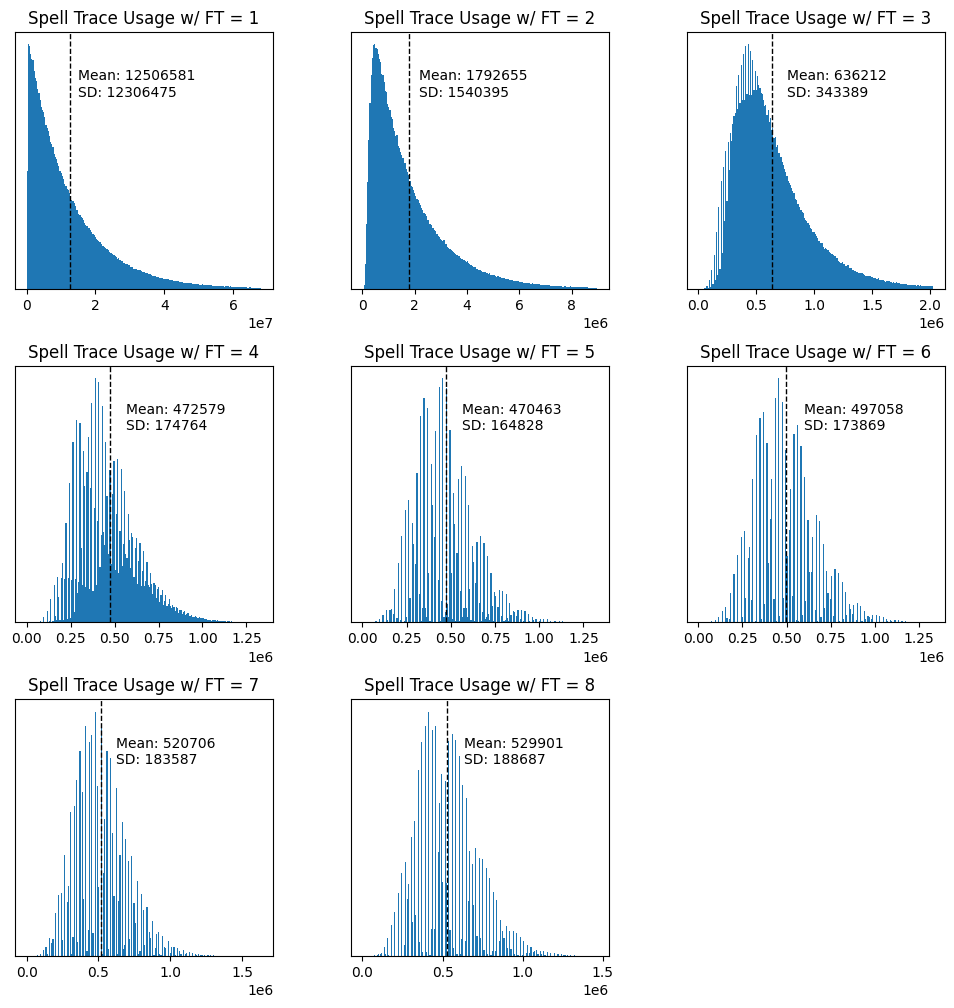

In [15]:
# begin plotting each distribution for total trace cost first (it should not be normal as it is the sum of three different distributions)
fig, plots = plt.subplots(int(np.ceil(np.sqrt(totUniqueCombs))), int(np.ceil(np.sqrt(totUniqueCombs))), figsize = (12, 12))

# flatten our plot (irrelevant in this case)
plots = [plot for plotRow in plots for plot in plotRow]

# The graphs seem to be heavily one-sided so this can manipulate the boundaries to be more visible
maxWeights = [0.4, 0.4, 0.4, 0.7, 0.8, 0.8, 0.8, 0.8]

# Then plot each element in the grid as a histogram
for plotInd in range(totUniqueCombs):
    relDf = resDf[resDf['Inno Fail Count'] == plotInd + 1]
    relDf.hist('totalTraceCost', ax = plots[plotInd], bins = 200, range = [0, maxWeights[plotInd]*relDf['totalTraceCost'].max()], density = True)
    plots[plotInd].set_title("Spell Trace Usage w/ FT = {}".format(plotInd+1))
    plots[plotInd].grid(False)

    # plot a meanline for more info
    curMean = relDf['totalTraceCost'].mean()
    curStd = relDf['totalTraceCost'].std()
    plots[plotInd].axvline(curMean, color = 'k', linestyle = 'dashed', linewidth = 1)
    plots[plotInd].text(curMean*1.2, plots[plotInd].get_ylim()[1]*0.75, 'Mean: {:.0f}\nSD: {:.0f}'.format(curMean, curStd))

    # remove y-lim (as it has no intrinsic meaning in a pdf plot)
    plots[plotInd].get_yaxis().set_visible(False)

# And disable any unnecessary plots
for plotInd in range(totUniqueCombs, len(plots)):
    plots[plotInd].set_visible(False)

So it seems from the above that the optimal fail tolerance should be around 4 to 5. In other words, if we fail 5 times before finishing up the equip, it's better to just innocence scroll and try again for a lower number of failures. To look at this another way, we simply require that at least 3/4 scrolls pass for an 8 slot item. Considering the scrolls being used are $29\%$ scrolls, this looks like just above the expected rate for these scrolls to pass in an equip with 10 total slots (8+2 hammered slots).

Of course, remember that the algorithm had a baked in assumption: we *do not* ever use an innocence scroll after hammering our slots. This might make no sense, but considering that the final slots should not be the ultimate determinant of when to stop, it seemed like a plausible decision to make for the simulation.

With that being said, we might also be interested in how the above costs are generated with respect to the three components that generate the costs (innocence scrolls, clean slate scrolls, and the stat scrolls being used). We show that below as a series of histograms with each of the respective average costs plotted for each sub-portion of the simulation.

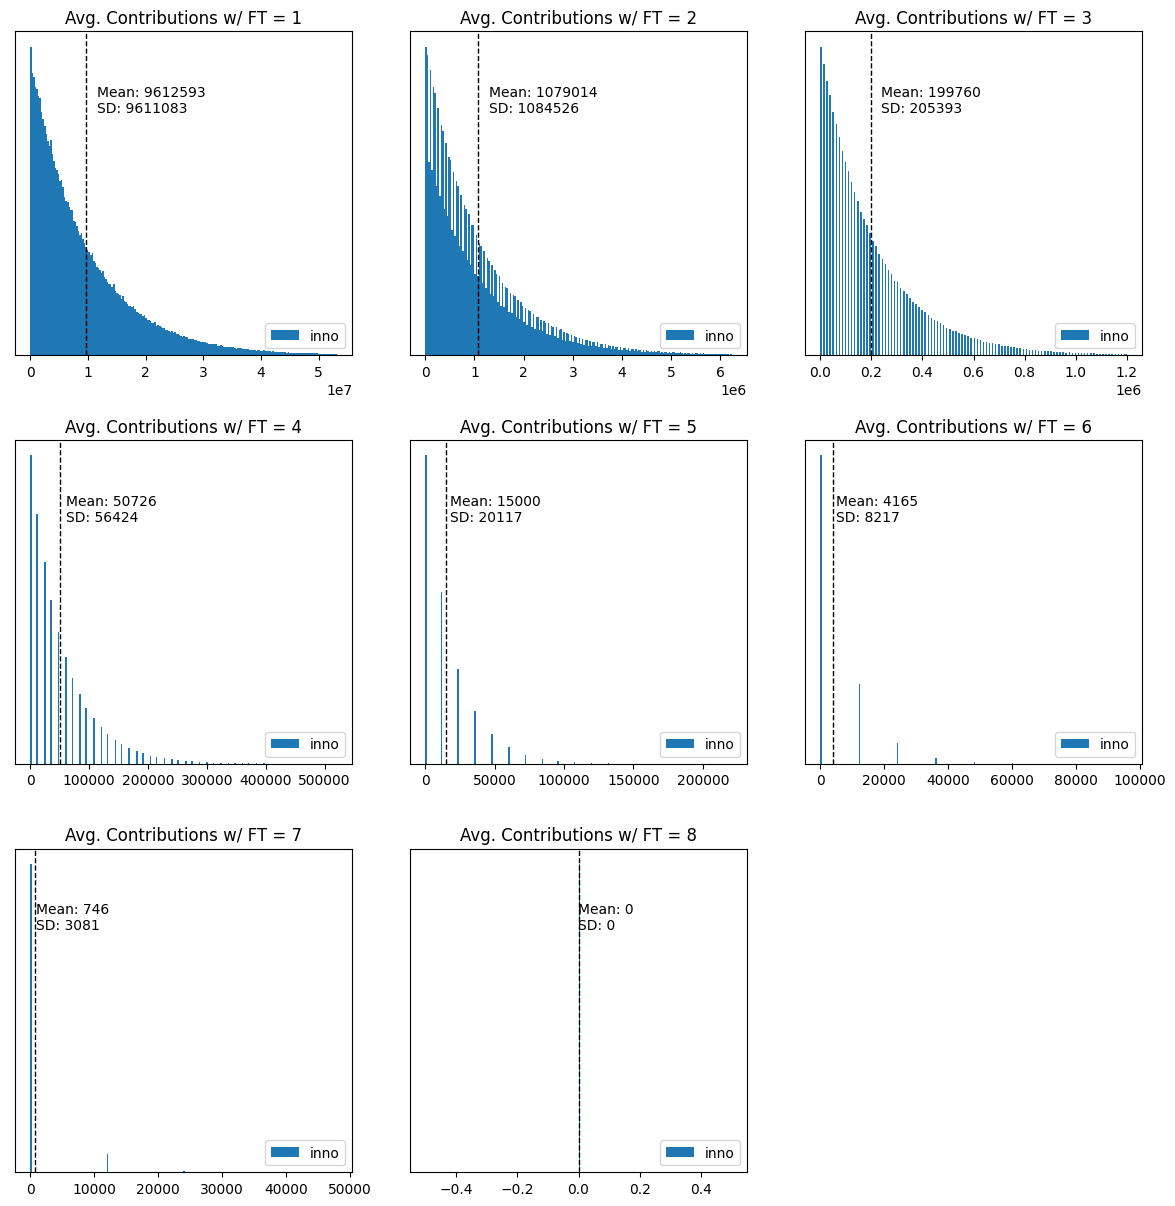

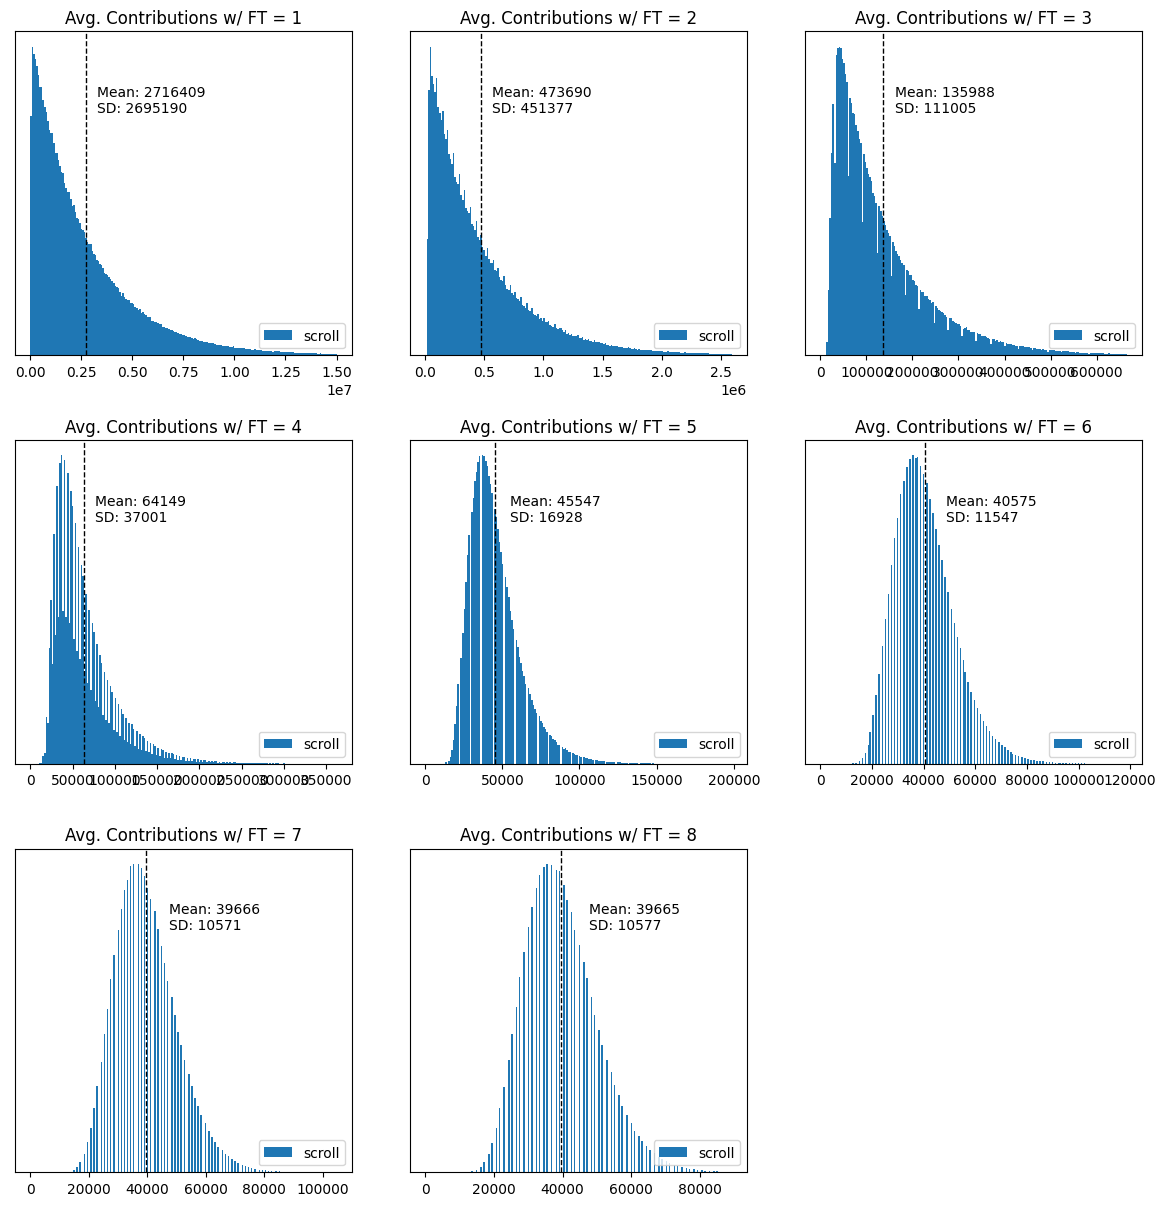

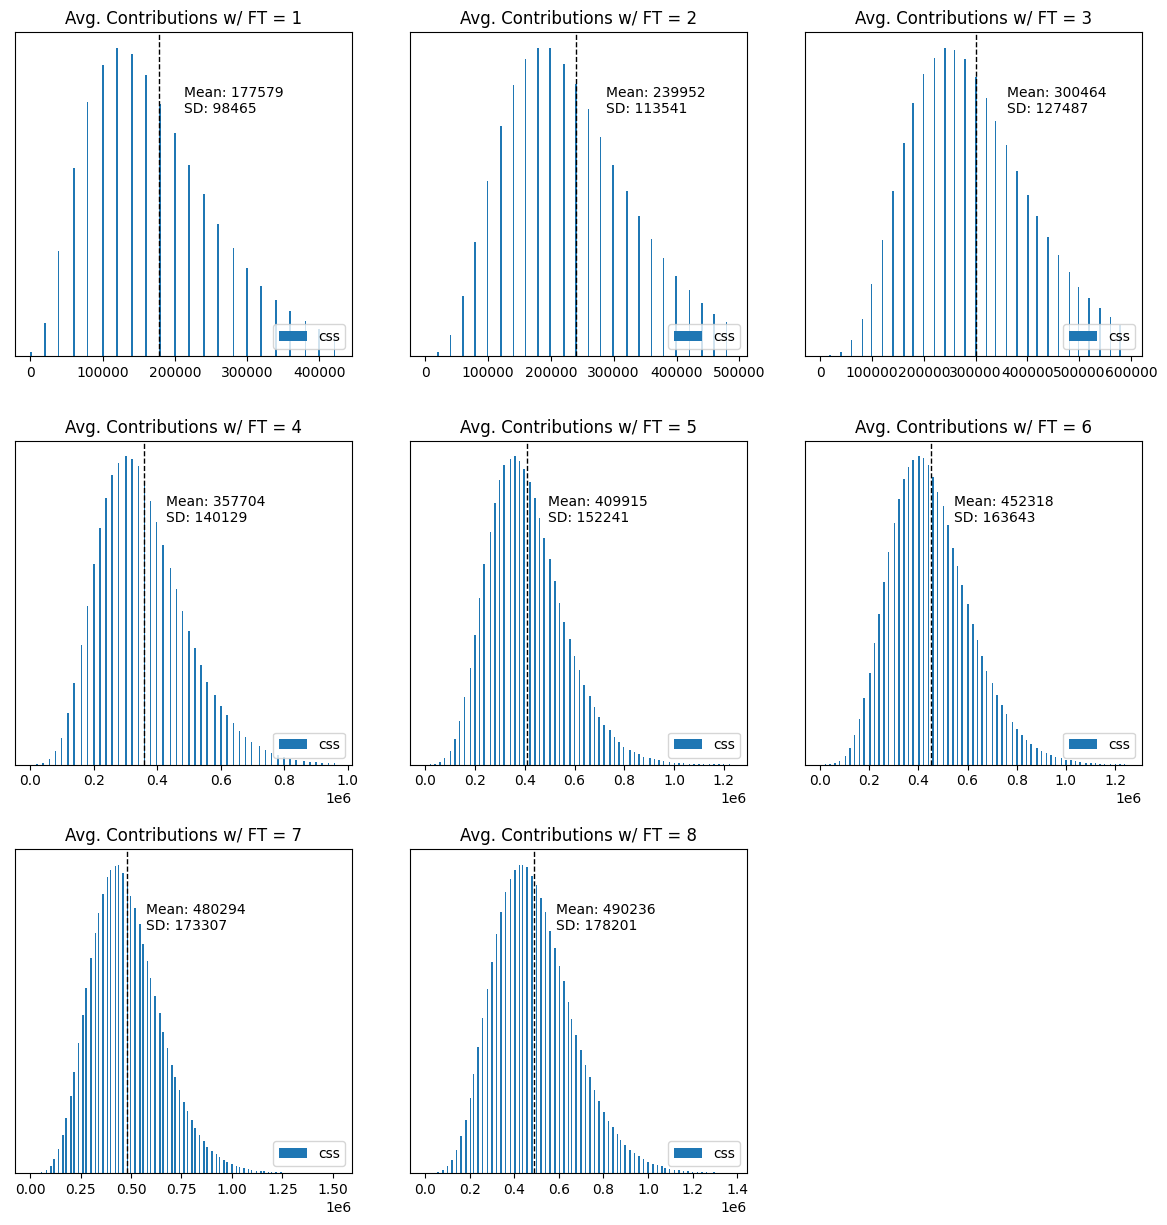

In [22]:
for plotVal in ['inno', 'scroll', 'css']:
    figStacked, plotsStacked = plt.subplots(int(np.ceil(np.sqrt(totUniqueCombs))), int(np.ceil(np.sqrt(totUniqueCombs))), figsize = (12, 12))
    figStacked.tight_layout(h_pad=4.0)
    plotsStacked = [plot for plotRow in plotsStacked for plot in plotRow]

    for plotInd in range(totUniqueCombs):
        # seperate desired dataframe segment
        relDf = resDf[resDf['Inno Fail Count'] == plotInd + 1]

        # and plot it
        plotsStacked[plotInd].hist(relDf[[plotVal+'TraceCost']].to_numpy(), 200, range = [0, maxWeights[plotInd]*relDf[plotVal+'TraceCost'].max()], 
                                density = True, label = plotVal)
        plotsStacked[plotInd].legend(loc='lower right')
        plotsStacked[plotInd].set_title("Avg. Contributions w/ FT = {}".format(plotInd+1))
        plotsStacked[plotInd].grid(False)

        # plot a meanline for more info
        curMean = relDf[plotVal+'TraceCost'].mean()
        curStd = relDf[plotVal+'TraceCost'].std()
        plotsStacked[plotInd].axvline(curMean, color = 'k', linestyle = 'dashed', linewidth = 1)
        plotsStacked[plotInd].text(curMean*1.2, plotsStacked[plotInd].get_ylim()[1]*0.75, 'Mean: {:.0f}\nSD: {:.0f}'.format(curMean, curStd))

        # remove y-lim (as it has no intrinsic meaning in a pdf plot)
        plotsStacked[plotInd].get_yaxis().set_visible(False)

    # And disable any unnecessary plots
    for plotInd in range(totUniqueCombs, len(plots)):
        plotsStacked[plotInd].set_visible(False)

So pretty much what we can see is that in the case of prioritizing CSS scrolls, it tends to make up a majority of the cost. The reason for the aliased looking plot is largely due to the large cost of using a CSS compared to the overall graph (each CSS costs about 20k traces per application, which is quite significant). The larger the cost of the elements being used, the higher the aliasing will appear in a blown out fashion.
Similarly, prioritizing innocence scrolling earlier reduces our css costs, but it's quite obvious that the likelihood of arriving at our designated non-inno point is quite difficult the more slots an item has. Of course, this is for a 29% spell trace scroll, which means there may be some benefit to investigating what happens during fever time (when it becomes 39%). We can investigate this below now.

## Modified Cost/Chance Times

With everything above reinforcing our idea that the algorithm is properly working, we can now investigate the difference between the scrolling process during fever time and without fever (or 50% of spell traces) time to see what happens with the above plots with that in mind.

In [23]:
# load in data much like the previous way
with open("./res_output_fever.pkl", 'rb') as inFile:
    resFeverDicts = pickle.load(inFile)

# first try ingesting via json method per key
keyDfs = list()
for keyVal in resFeverDicts.keys():
    keyDfs.append(pd.DataFrame.from_dict(resFeverDicts[keyVal]))

    # manipulate into containing the desired elements from keys
    for varName, varVal in keyVal:
        keyDfs[-1][varName] = varVal
    
# Then concatenate all results along with their variadic key values
resFeverDf = pd.concat(keyDfs, axis = 0)
totUniqueFeverCombs = len(resFeverDicts.keys())

# And cleanup all the unnecessary garbage from the process
del keyDfs
del resFeverDicts

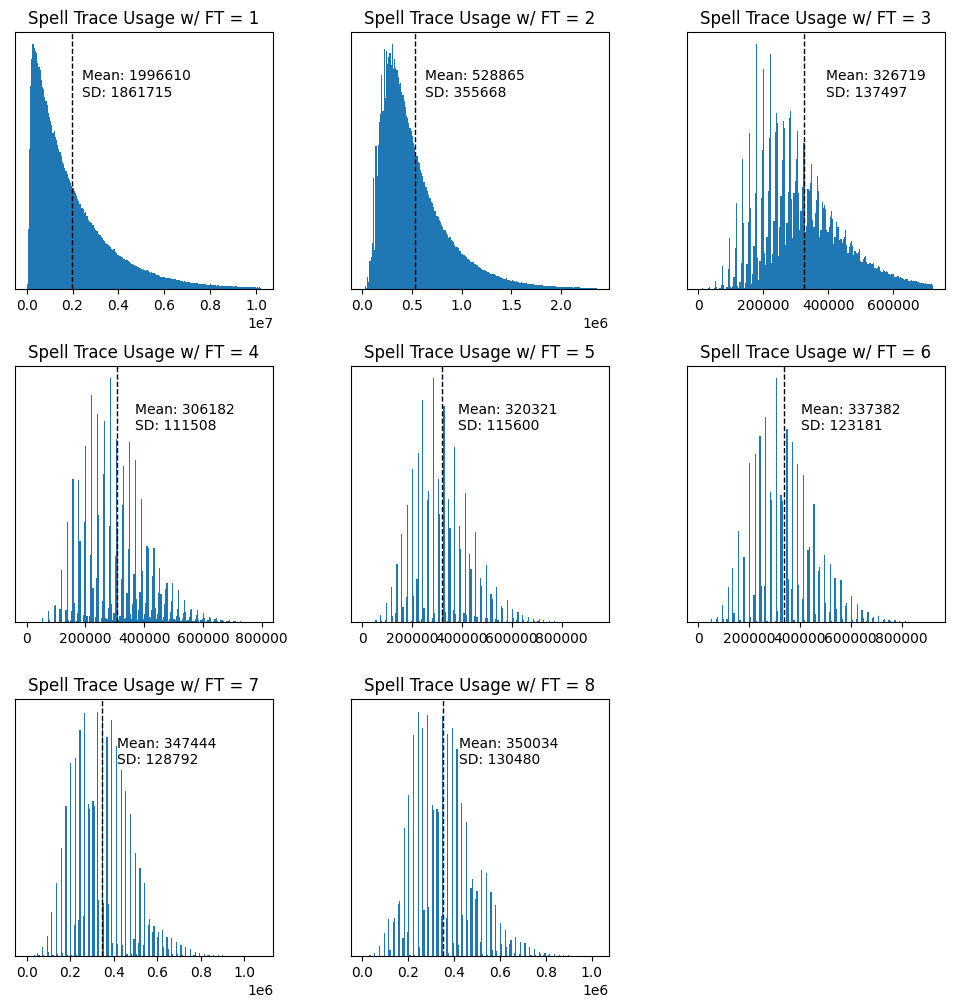

In [24]:
# begin plotting each distribution for total trace cost first (it should not be normal as it is the sum of three different distributions)
fig, plots = plt.subplots(int(np.ceil(np.sqrt(totUniqueCombs))), int(np.ceil(np.sqrt(totUniqueCombs))), figsize = (12, 12))

# flatten our plot (irrelevant in this case)
plots = [plot for plotRow in plots for plot in plotRow]

# The graphs seem to be heavily one-sided so this can manipulate the boundaries to be more visible
maxWeights = [0.4, 0.4, 0.4, 0.7, 0.8, 0.8, 0.8, 0.8]

# Then plot each element in the grid as a histogram
for plotInd in range(totUniqueCombs):
    relDf = resFeverDf[resFeverDf['Inno Fail Count'] == plotInd + 1]
    relDf.hist('totalTraceCost', ax = plots[plotInd], bins = 200, range = [0, maxWeights[plotInd]*relDf['totalTraceCost'].max()], density = True)
    plots[plotInd].set_title("Spell Trace Usage w/ FT = {}".format(plotInd+1))
    plots[plotInd].grid(False)

    # plot a meanline for more info
    curMean = relDf['totalTraceCost'].mean()
    curStd = relDf['totalTraceCost'].std()
    plots[plotInd].axvline(curMean, color = 'k', linestyle = 'dashed', linewidth = 1)
    plots[plotInd].text(curMean*1.2, plots[plotInd].get_ylim()[1]*0.75, 'Mean: {:.0f}\nSD: {:.0f}'.format(curMean, curStd))

    # remove y-lim (as it has no intrinsic meaning in a pdf plot)
    plots[plotInd].get_yaxis().set_visible(False)

# And disable any unnecessary plots
for plotInd in range(totUniqueCombs, len(plots)):
    plots[plotInd].set_visible(False)

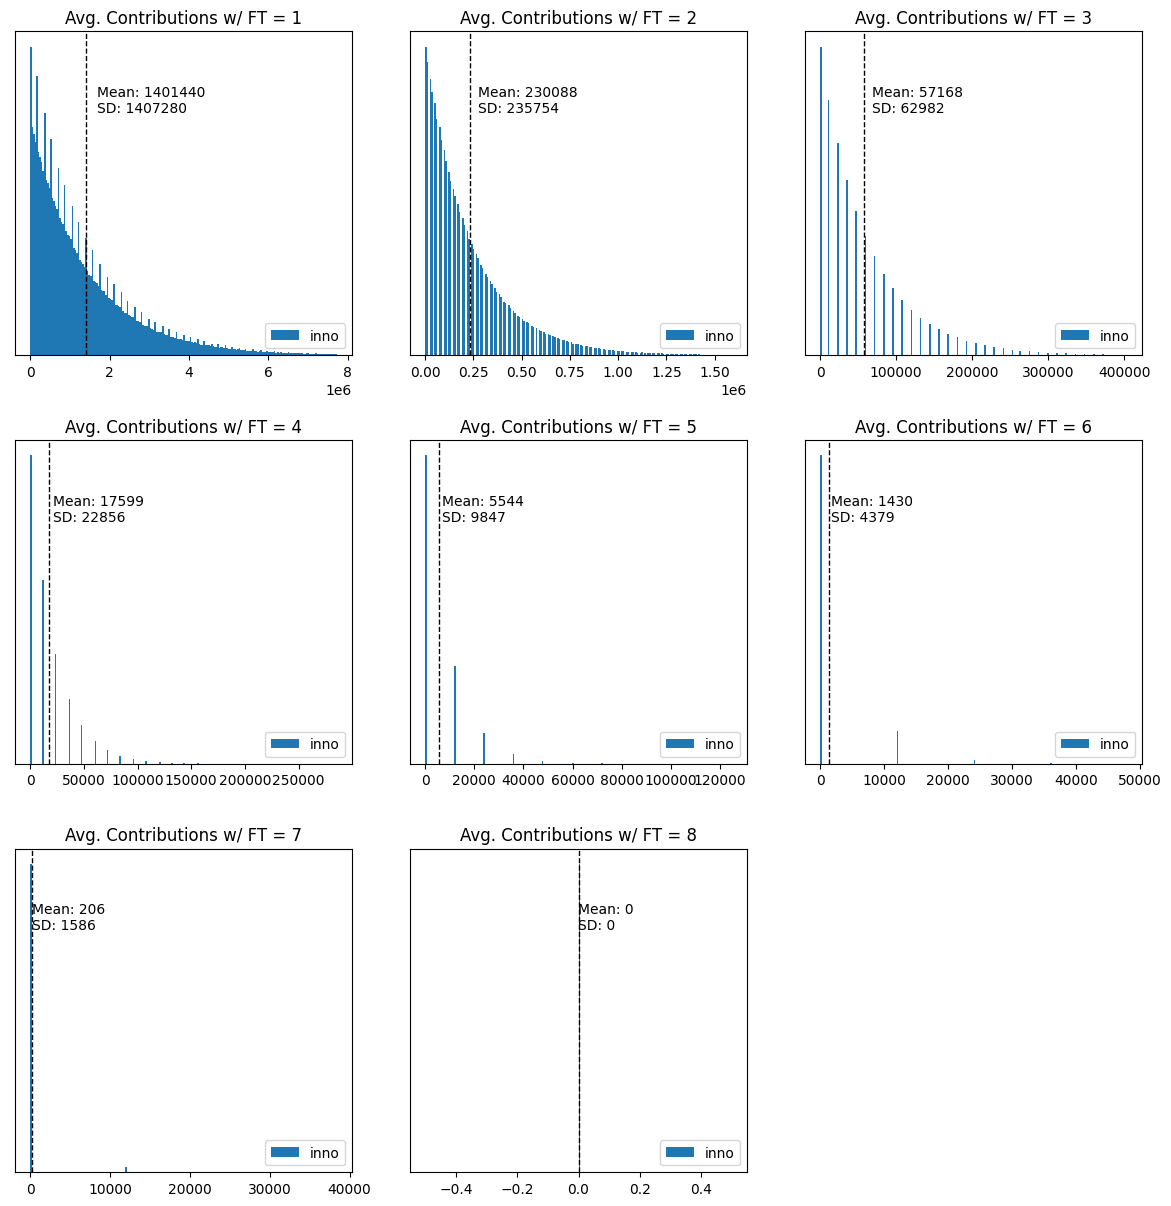

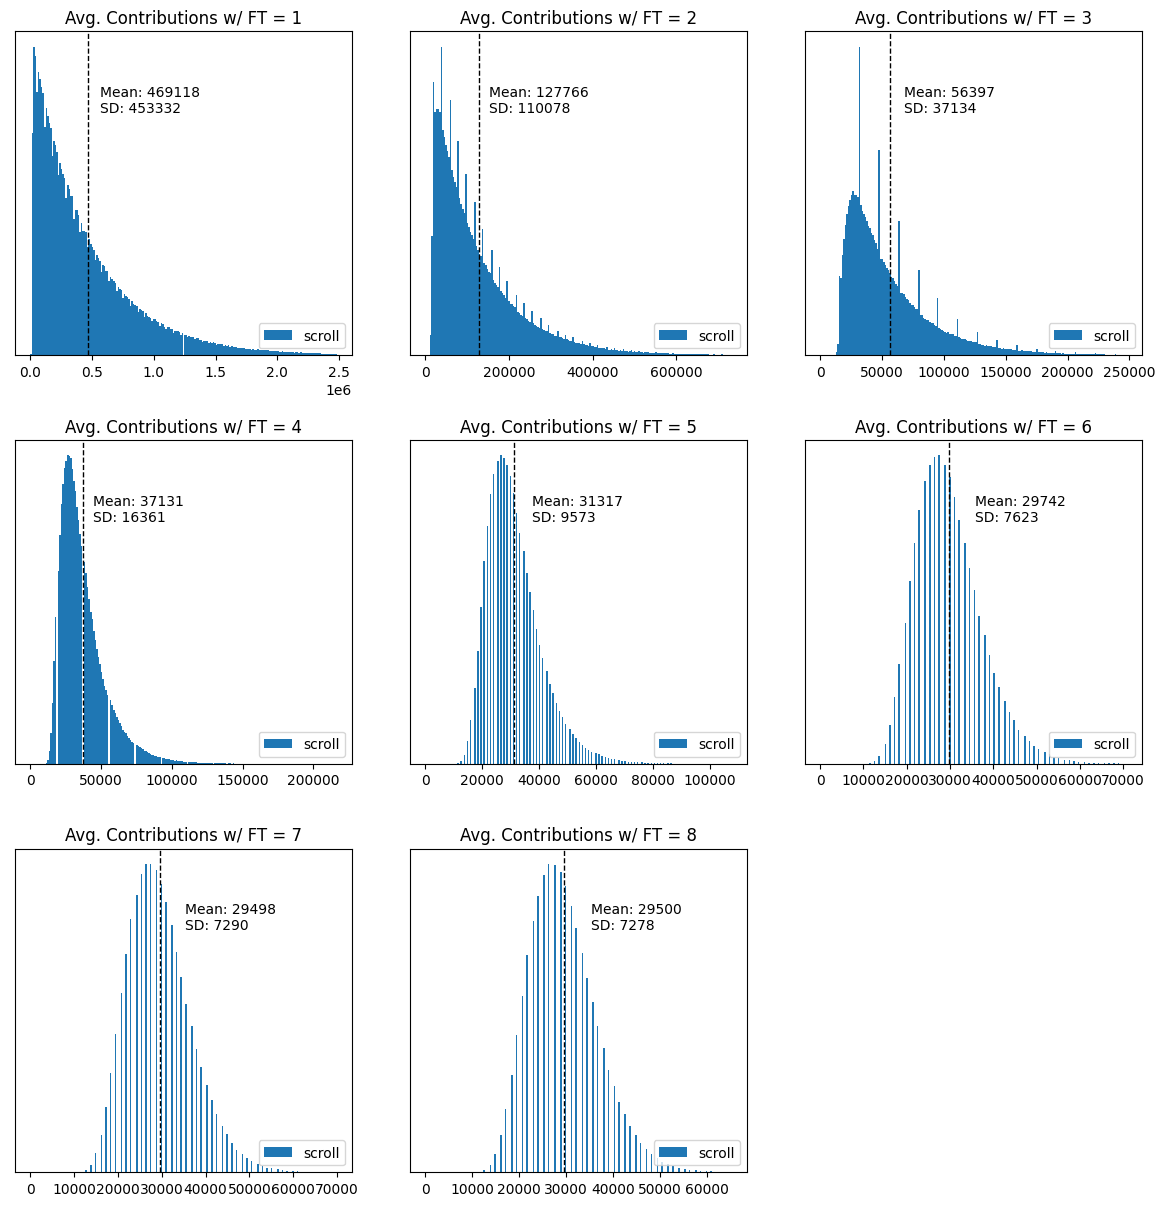

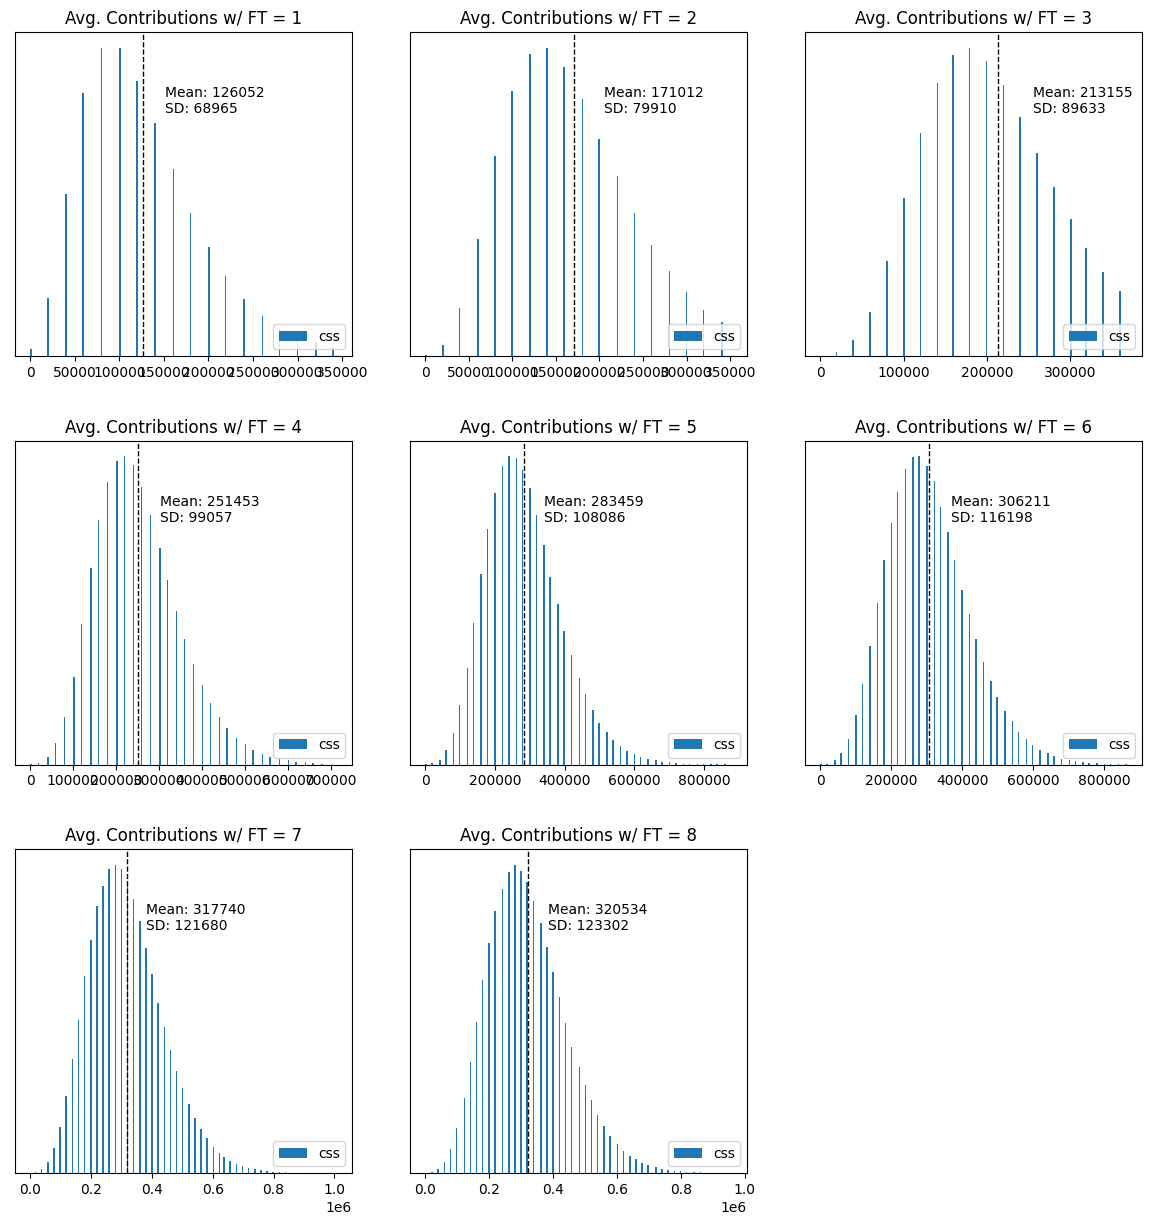

In [25]:
for plotVal in ['inno', 'scroll', 'css']:
    figStacked, plotsStacked = plt.subplots(int(np.ceil(np.sqrt(totUniqueCombs))), int(np.ceil(np.sqrt(totUniqueCombs))), figsize = (12, 12))
    figStacked.tight_layout(h_pad=4.0)
    plotsStacked = [plot for plotRow in plotsStacked for plot in plotRow]

    for plotInd in range(totUniqueCombs):
        # seperate desired dataframe segment
        relDf = resFeverDf[resFeverDf['Inno Fail Count'] == plotInd + 1]

        # and plot it
        plotsStacked[plotInd].hist(relDf[[plotVal+'TraceCost']].to_numpy(), 200, range = [0, maxWeights[plotInd]*relDf[plotVal+'TraceCost'].max()], 
                                density = True, label = plotVal)
        plotsStacked[plotInd].legend(loc='lower right')
        plotsStacked[plotInd].set_title("Avg. Contributions w/ FT = {}".format(plotInd+1))
        plotsStacked[plotInd].grid(False)

        # plot a meanline for more info
        curMean = relDf[plotVal+'TraceCost'].mean()
        curStd = relDf[plotVal+'TraceCost'].std()
        plotsStacked[plotInd].axvline(curMean, color = 'k', linestyle = 'dashed', linewidth = 1)
        plotsStacked[plotInd].text(curMean*1.2, plotsStacked[plotInd].get_ylim()[1]*0.75, 'Mean: {:.0f}\nSD: {:.0f}'.format(curMean, curStd))

        # remove y-lim (as it has no intrinsic meaning in a pdf plot)
        plotsStacked[plotInd].get_yaxis().set_visible(False)

    # And disable any unnecessary plots
    for plotInd in range(totUniqueCombs, len(plots)):
        plotsStacked[plotInd].set_visible(False)

As for the 50% sessions, we can simply scale everything down by 50%. Taking that into consideration, having a day with both 50% off and fever can help to significantly reduce the overall costs of spell tracing. The difference between regular spell tracing and fever seems to be a ~36% overall reduction in the overall cost of spell tracing. 50% spell trace events reduce the overall cost of the original by 50% (obviously). Fever affects the scrolls the most, so it makes sense that its variance would go down as a result, but, unfortunately, it didn't have too large of a result on the overall costs due to the imbalance between the scroll and css/inno cost.

With that being said, the priority might actually be to wait for a 50% off event as 100% innocence scrolls and clean slate scrolls do not actually benefit from fever events! Or, if time is not the problem, the ideal would be to take advantage of the higher scroll rates during fever and use 50% off events to apply the requisite css scrolls. In an ideal situation, you take advantage of both and you definitely wait for at least 4/5 passes in a fever scenario, but if tracing outside the event is necessary, you may have to settle for the lower 3/4 success pass for the time being.